## 1.Load and process the trade and quote data as in class

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.interpolation import shift
import pandas as pd
import time
import datetime
from sklearn import linear_model as linear_model
matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
def show_time( label_string ):
    ts = time.time()
    st = datetime.datetime.fromtimestamp( ts ).strftime( '%Y-%m-%d %H:%M:%S:%f' )
    print( label_string + ' : ' + st )

## Load the data at first time

In [9]:
# load trades
show_time( 'started loading trades' )
trades = pd.read_csv( 'SQ_trades_201902.zip' )
show_time( 'finished loading trades')

# index trades
show_time( 'started fixing trade index')

# fix column names
trades = trades.rename( index=str, columns={ 'SIZE' : 'trade_qty', 'PRICE' : 'trade_price' } )

# fix index
times = trades[ 'DATE' ].astype( str ) + trades[ 'TIME_M' ].astype( str )
formatStr = '%Y%m%d%H:%M:%S.%f'
trades.index = pd.to_datetime( times, format = formatStr )

# clean up unused columns
trades = trades.drop( columns=[ 'DATE', 'TIME_M', 'SYM_ROOT', 'SYM_SUFFIX', 'TR_CORR', 'TR_SEQNUM', 'TR_RF' ] )
show_time( 'finished fixing trade index' )

started loading trades : 2019-05-03 07:41:30:368653
finished loading trades : 2019-05-03 07:41:33:538403
started fixing trade index : 2019-05-03 07:41:33:538640
finished fixing trade index : 2019-05-03 07:41:47:223675


In [21]:
trades.tail()

,EX,TR_SCOND,trade_qty,trade_price,TR_SOURCE
2019-02-28 19:59:26.015652,K,FT,100,81.2000,C
2019-02-28 19:59:26.238946,K,FT,100,81.2000,C
2019-02-28 19:59:26.487298,K,FT,100,81.2000,C
2019-02-28 19:59:39.024485,D,T,8000,81.1600,C
2019-02-28 19:59:40.458399,D,T,200,81.1999,C


In [6]:
# load quotes
show_time( 'started loading quotes' )
quotes = pd.read_csv( 'SQ_quotes_201902.zip' )
show_time( 'finished loading quotes')

# index trades
show_time( 'started fixing quotes index' )

# fix column names
quotes = quotes.rename( index=str, columns={ 'BID' : 'bid_price', 'BIDSIZ' : 'bid_qty', 'ASK' : 'ask_price', 'ASKSIZ' : 'ask_qty' } )

# fix index
times = quotes[ 'DATE' ].astype( str ) + ' '+quotes[ 'TIME_M' ].astype( str )
formatStr = '%Y%m%d %H:%M:%S.%f'
quotes.index = pd.to_datetime( times, format = formatStr )

# cleanup unused columns
quotes = quotes.drop( columns=[ 'DATE', 'TIME_M', 'QU_SEQNUM', 'QU_SOURCE', 'SYM_ROOT', 'SYM_SUFFIX' ] )
show_time( 'finished fixing quotes index' )

started loading quotes : 2019-05-03 07:38:08:568449
finished loading quotes : 2019-05-03 07:39:02:727681
started fixing quotes index : 2019-05-03 07:39:02:750139
finished fixing quotes index : 2019-05-03 07:40:35:424952


In [10]:
daytrades = trades['2019-02-01 09:30:00':'2019-02-04 16:00:00']


In [8]:
dayquotes = quotes['2019-02-01 09:30:00':'2019-02-04 16:00:00']

In [11]:
# now merge quote and tick data
show_time( 'start merge' )
taq = dayquotes.merge( daytrades, how = 'outer', left_index = True, right_index = True )
show_time( 'end merge' )

start merge : 2019-05-03 07:42:05:404195
end merge : 2019-05-03 07:42:06:824878


In [7]:
taq.tail()

,EX_x,bid_price,bid_qty,ask_price,ask_qty,QU_COND,NATBBO_IND,QU_CANCEL,EX_y,TR_SCOND,trade_qty,trade_price,TR_SOURCE
2019-02-01 16:00:00.000000,J,66.97,1.0,0.0,0.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 16:00:00.000000,B,66.97,1.0,0.0,0.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 16:00:00.000000,Z,70.77,6.0,72.5,1.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 16:00:00.155493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,M,900.0,70.80,C
2019-02-01 16:00:00.371051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T,M,100.0,70.81,C


In [8]:
print(len(taq))
print(len(trades))
print(len(quotes))

1074274
1158991
1014024


In [8]:
daytrades.head()

,EX,TR_SCOND,trade_qty,trade_price,TR_SOURCE
2019-02-01 09:30:00.670951,N,O,110097,71.05,C
2019-02-01 09:30:00.673518,N,NaN,300,71.05,C
2019-02-01 09:30:00.674397,N,NaN,100,71.01,C
2019-02-01 09:30:00.692836,N,I,75,71.00,C
2019-02-01 09:30:00.694405,N,F,100,71.07,C


In [12]:
taq.to_pickle("SQ_taq_20190201-04.zip")

In [13]:
daytrades.to_pickle("SQ_trades_20190201-04.zip")

In [14]:
dayquotes.to_pickle("SQ_quotes_20190201-04.zip")

## load processed data every time

In [15]:
taq = pd.read_pickle( 'SQ_taq_20190201-04.zip' )
taq1 = taq['2019-02-01 09:30:00':'2019-02-01 16:00:00']
taq2 = taq['2019-02-04 09:30:00':'2019-02-04 16:00:00']

In [40]:
taq1.head()

,EX_x,bid_price,bid_qty,ask_price,ask_qty,QU_COND,NATBBO_IND,QU_CANCEL,EX_y,TR_SCOND,trade_qty,trade_price,TR_SOURCE
2019-02-01 09:30:00.009266216,T,70.67,2.0,71.50,1.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 09:30:00.041351695,Z,70.56,1.0,71.09,17.0,R,U,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 09:30:00.041469452,K,70.80,1.0,71.09,8.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 09:30:00.041724945,T,70.67,2.0,71.09,12.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 09:30:00.056688719,P,70.95,2.0,71.09,15.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
taq2.head()

,EX_x,bid_price,bid_qty,ask_price,ask_qty,QU_COND,NATBBO_IND,QU_CANCEL,EX_y,TR_SCOND,trade_qty,trade_price,TR_SOURCE
2019-02-04 09:30:00.012472744,T,70.32,1.0,70.85,1.0,R,U,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-04 09:30:00.012724711,X,70.26,21.0,71.05,2.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-04 09:30:00.012766181,Y,70.61,5.0,70.98,5.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-04 09:30:00.012806507,J,70.60,1.0,70.99,1.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-04 09:30:00.012822152,B,70.28,8.0,71.05,2.0,R,U,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
taq2.tail()

,EX_x,bid_price,bid_qty,ask_price,ask_qty,QU_COND,NATBBO_IND,QU_CANCEL,EX_y,TR_SCOND,trade_qty,trade_price,TR_SOURCE
2019-02-04 16:00:00.366627039,C,0.00,0.0,0.00,0.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-04 16:00:00.432033556,T,71.70,1.0,71.93,1.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-04 16:00:00.436612882,T,71.69,1.0,71.93,1.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-04 16:00:00.441086098,T,71.68,1.0,71.93,1.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-04 16:00:00.445611264,T,71.30,1.0,71.93,1.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
dayquotes = pd.read_pickle ( 'SQ_quotes_20190201-04.zip' )



In [17]:
daytrades = pd.read_pickle ( 'SQ_trades_20190201-04.zip' )
daytrades1 = daytrades['2019-02-01 09:30:00':'2019-02-01 16:00:00']
daytrades2 = daytrades['2019-02-04 09:30:00':'2019-02-04 16:00:00']

## 2.VWAP Profile

In [18]:
# now let's make some 1 minute data using resample
minute_data = pd.DataFrame()
minute_data['open'] = daytrades1['trade_price'].resample('Min').first()
minute_data['close'] = daytrades1['trade_price'].resample('Min').last()
minute_data['high'] = daytrades1['trade_price'].resample('Min').max()
minute_data['low'] = daytrades1['trade_price'].resample('Min').min()
minute_data['volume'] = daytrades1['trade_qty'].resample('Min').sum()

In [33]:
minute_data.head()

,open,close,high,low,volume,accum_volume,accum_pct,minute_bars
2019-02-01 09:30:00,71.0500,71.0700,71.220,70.76,210467,210467,0.017249,0
2019-02-01 09:31:00,71.0732,71.0101,71.210,71.00,33881,244348,0.020026,1
2019-02-01 09:32:00,71.1200,70.6095,71.210,70.60,68409,312757,0.025633,2
2019-02-01 09:33:00,70.6700,70.4622,70.810,70.40,186051,498808,0.040881,3
2019-02-01 09:34:00,70.4600,70.4800,70.585,70.41,89487,588295,0.048215,4


In [43]:
minute_data.tail()

,open,close,high,low,volume,accum_volume,accum_pct,minute_bars
2019-02-01 15:56:00,71.020,70.9844,71.020,70.950,41909,11689065,0.957997,386
2019-02-01 15:57:00,70.980,70.9750,71.015,70.965,65094,11754159,0.963332,387
2019-02-01 15:58:00,70.985,70.9350,70.990,70.920,124529,11878688,0.973538,388
2019-02-01 15:59:00,70.940,70.7900,70.960,70.770,321877,12200565,0.999918,389
2019-02-01 16:00:00,70.800,70.8100,70.810,70.800,1000,12201565,1.000000,390


In [19]:
# calculate the cumulative pct by day
minute_data[ 'accum_volume' ] = minute_data.groupby( [ minute_data.index.date ] ).cumsum()[ 'volume' ] 
minute_data[ 'accum_pct' ] = minute_data.groupby( [ minute_data.index.date ] )[ 'accum_volume' ].transform( lambda x: x / x.iloc[ -1 ] )

In [12]:
minute_data.tail()

,open,close,high,low,volume,minute_bars,accum_volume,accum_pct
2019-02-01 15:56:00,71.020,70.9844,71.020,70.950,41909,386,11689065,0.957997
2019-02-01 15:57:00,70.980,70.9750,71.015,70.965,65094,387,11754159,0.963332
2019-02-01 15:58:00,70.985,70.9350,70.990,70.920,124529,388,11878688,0.973538
2019-02-01 15:59:00,70.940,70.7900,70.960,70.770,321877,389,12200565,0.999918
2019-02-01 16:00:00,70.800,70.8100,70.810,70.800,1000,390,12201565,1.000000


In [20]:
# add a minute bin
# US start of date, calc in minutes
start_of_day = ( 9 * 60 ) + 30
# get the time for each bin in minutes and subtract 9:30
minute_data[ 'minute_bars' ] = ( minute_data.index.hour * 60 ) + minute_data.index.minute - start_of_day

In [67]:
minute_data.head()

,open,close,high,low,volume,accum_volume,accum_pct,minute_bars
2019-02-01 09:30:00,71.0500,71.0700,71.220,70.76,210467,210467,0.017249,0
2019-02-01 09:31:00,71.0732,71.0101,71.210,71.00,33881,244348,0.020026,1
2019-02-01 09:32:00,71.1200,70.6095,71.210,70.60,68409,312757,0.025633,2
2019-02-01 09:33:00,70.6700,70.4622,70.810,70.40,186051,498808,0.040881,3
2019-02-01 09:34:00,70.4600,70.4800,70.585,70.41,89487,588295,0.048215,4


In [21]:
# arrange our data
minute_bars = minute_data[ 'minute_bars' ]
X = pd.DataFrame( { 'bin': minute_bars, 
                    'bin2' : minute_bars**2, 
                    'bin3' : minute_bars**3, 
                    'bin4' : minute_bars**4, 
                    'bin5' : minute_bars**5 } )
y = minute_data[ 'accum_pct' ]

In [22]:
# now do the regression
lm = linear_model.LinearRegression()
model = lm.fit( X, y )
predictions = lm.predict( X )
# Rsquared
lm.score( X, y )

0.9989652741407131

In [23]:
# do we have any null values?
y[y.isnull()]

Series([], Freq: T, Name: accum_pct, dtype: float64)

In [24]:
len(X)

391

In [25]:
# coefficients
lm.coef_

array([ 8.54232435e-03, -6.31385359e-05,  2.81254690e-07, -6.15092717e-10,
        5.28396280e-13])

In [26]:
lm.intercept_

0.018688549293718104

In [27]:
# now do the regression with no intercept
lm2 = linear_model.LinearRegression( fit_intercept = False )
model = lm2.fit( X, y )
predictions = lm2.predict( X )

# Rsquared
lm2.score( X, y )

0.9987678965127181

In [28]:
lm2.coef_

array([ 9.37975866e-03, -7.45755149e-05,  3.47151656e-07, -7.83841929e-10,
        6.86846239e-13])

In [29]:
lm2.intercept_

0.0

In [30]:
predictions[- 1]

0.9711537332776516

In [31]:
''''''
def vwap_target( bar_num, coefs ):
    return ( coefs[ 0 ] * bar_num + 
             coefs[ 1 ] * bar_num**2 + 
             coefs[ 2 ] * bar_num**3 +
             coefs[ 3 ] * bar_num**4 +
             coefs[ 4 ] * bar_num**5 
''''''

In [32]:
#bins = np.arange(0,391)
#tgts = vwap_target( bins, lm2.coef_ )

In [82]:
#bins[0:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<function matplotlib.pyplot.show>

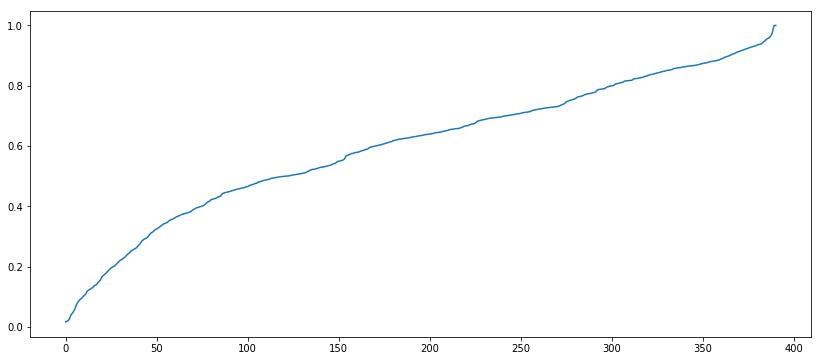

In [68]:
plt.plot(minute_data['minute_bars'], minute_data[ 'accum_pct' ])
plt.show

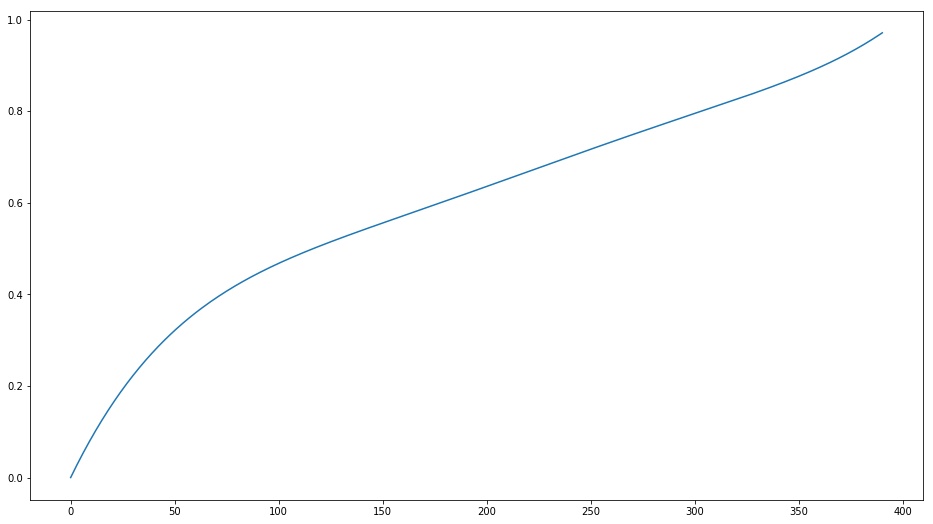

In [84]:
fig, ax1 = plt.subplots(figsize=(16,9))
plt.plot(predictions)

In [41]:
# or is there something about this that keeps it from getting to 1.0 that I'm forgetting?
minute_data.index

DatetimeIndex(['2019-02-01 09:30:00', '2019-02-01 09:31:00',
               '2019-02-01 09:32:00', '2019-02-01 09:33:00',
               '2019-02-01 09:34:00', '2019-02-01 09:35:00',
               '2019-02-01 09:36:00', '2019-02-01 09:37:00',
               '2019-02-01 09:38:00', '2019-02-01 09:39:00',
               ...
               '2019-02-01 15:51:00', '2019-02-01 15:52:00',
               '2019-02-01 15:53:00', '2019-02-01 15:54:00',
               '2019-02-01 15:55:00', '2019-02-01 15:56:00',
               '2019-02-01 15:57:00', '2019-02-01 15:58:00',
               '2019-02-01 15:59:00', '2019-02-01 16:00:00'],
              dtype='datetime64[ns]', length=391, freq='T')

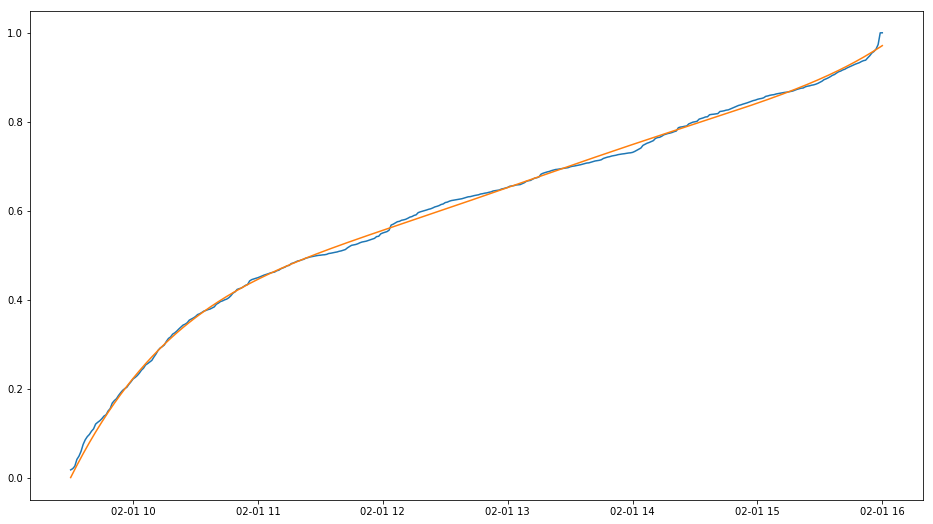

In [86]:
tgt_date = '2019-02-01'
fig, ax1 = plt.subplots( figsize = ( 16, 9 ) )
ax1.plot( minute_data[ 'accum_pct' ] )
tgtsSeries = pd.Series( predictions )
tgtsSeries.index = minute_data.index
ax1.plot( tgtsSeries )
plt.show()

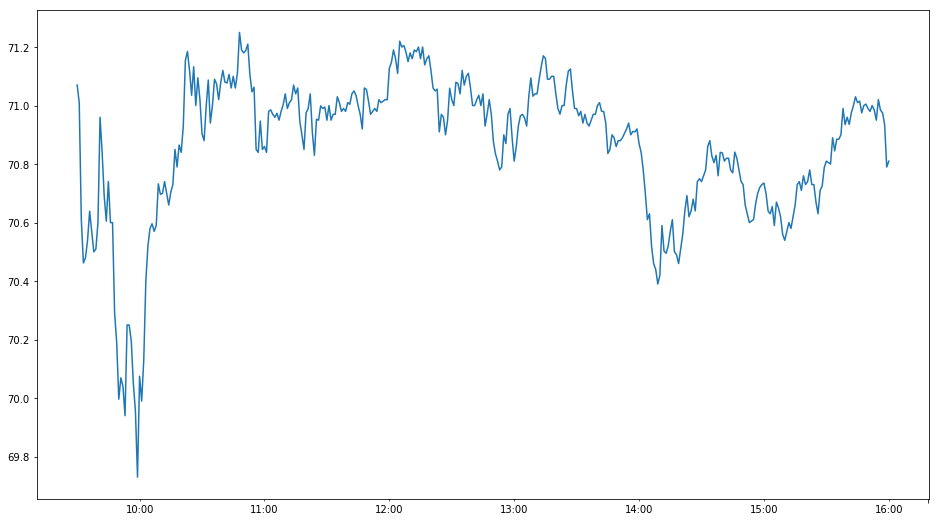

In [26]:
minute_data['close'].plot(figsize=(16,9))

## 3.run a modified VWAP Algo

In [26]:
''''''
# returns next minute target
# scale the last value to ensure it converges to 1 by the end and then shift the series by back by one
def get_vwap_targets( order_size, coefs ):
    bar_num = np.arange( 0, 391 )
    bar_pcts = ( coefs[ 0 ] * bar_num + 
                coefs[ 1 ] * bar_num ** 2 + 
                coefs[ 2 ] * bar_num ** 3 + 
                coefs[ 3 ] * bar_num ** 4 + 
                coefs[ 4 ] * bar_num ** 5 )
    bar_pcts = bar_pcts / ( coefs[ 0 ] * 390 + 
                coefs[ 1 ] * 390 ** 2 + 
                coefs[ 2 ] * 390 ** 3 + 
                coefs[ 3 ] * 390 ** 4 + 
                coefs[ 4 ] * 390 ** 5 )
    bar_pcts = shift( bar_pcts, -1, cval=1 )
    return np.minimum( ( bar_pcts * order_size ).astype( int ), order_size )
''''''

In [34]:
# returns next minute target
# scale the last value to ensure it converges to 1 by the end and then shift the series by back by one
def get_vwap_targets( order_size ):
    bar_pcts = predictions
    bar_pcts = bar_pcts / predictions[ -1]
    bar_pcts = shift( bar_pcts, -1, cval=1 )
    return np.minimum( ( bar_pcts * order_size ).astype( int ), order_size )

In [35]:
order_quantity = 300000

In [36]:
# generate target schedule - use bins 1 - 390 giving an automatic 1 minute "look ahead"
# note that targets have been converted to shares from percent
order_targets = get_vwap_targets( order_quantity )

In [37]:
len(order_targets)

391

In [38]:
order_targets[380:390]

array([291997, 292835, 293684, 294547, 295422, 296310, 297211, 298127,
       299056, 300000])

start loop : 2019-05-03 10:51:46:032155
end loop : 2019-05-03 10:53:45:913101
stock volume: 10133963.0
order shares traded: 299056.0
average price: 71.85434517281044
day vwap: 71.88287033318554
the difference:-0.028525160375096448
average trade size: 3603.0843373493976


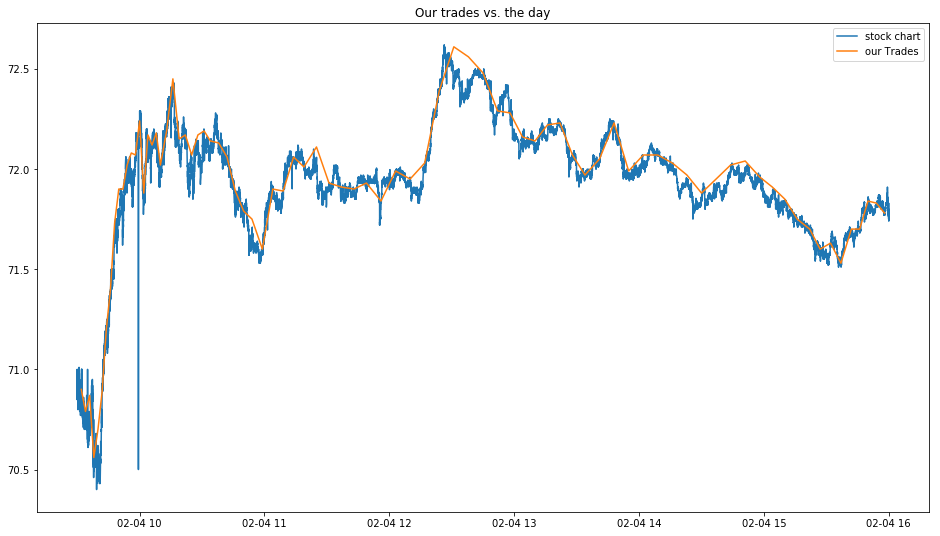

start loop : 2019-05-03 10:53:46:246380
end loop : 2019-05-03 10:55:45:642705
stock volume: 20267926.0
order shares traded: 299056.0
average price: 71.78627959311967
day vwap: 71.88287033318511
the difference:-0.09659074006543733
average trade size: 3560.190476190476


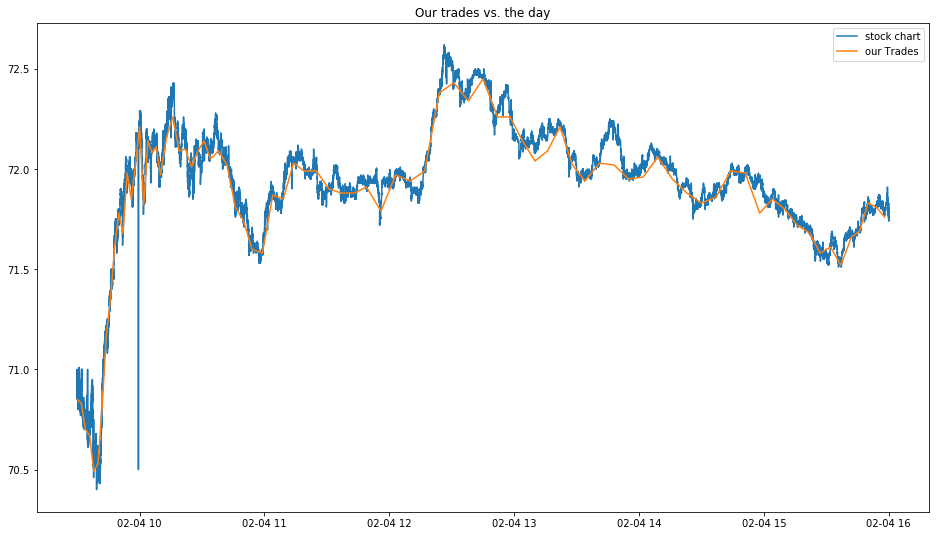

start loop : 2019-05-03 10:55:45:964389
end loop : 2019-05-03 10:57:47:194677
stock volume: 30401889.0
order shares traded: 295422.0
average price: 71.84492630880573
day vwap: 71.8828703331853
the difference:-0.037944024379569896
average trade size: 6422.217391304348


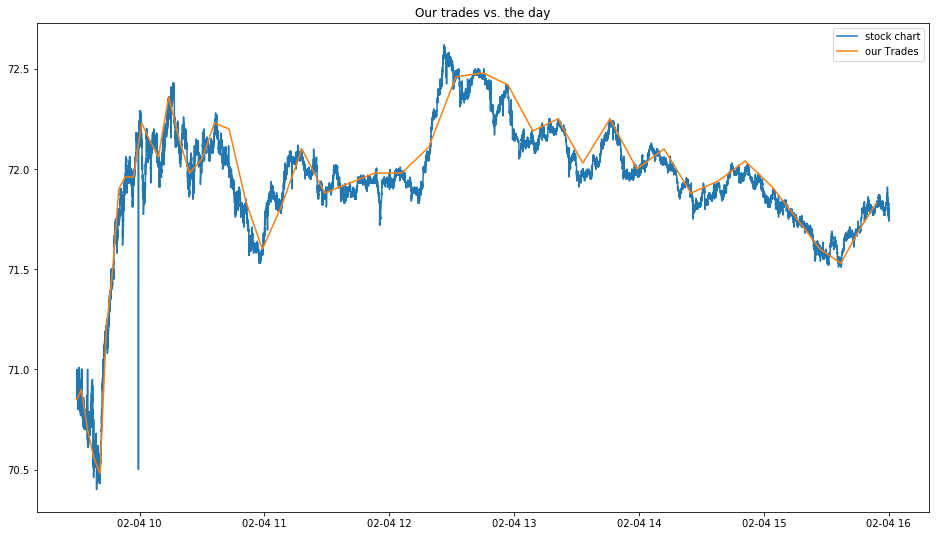

start loop : 2019-05-03 10:57:47:534873
end loop : 2019-05-03 10:59:52:893894
stock volume: 40535852.0
order shares traded: 295422.0
average price: 71.78468265735118
day vwap: 71.88287033318551
the difference:-0.09818767583432475
average trade size: 6422.217391304348


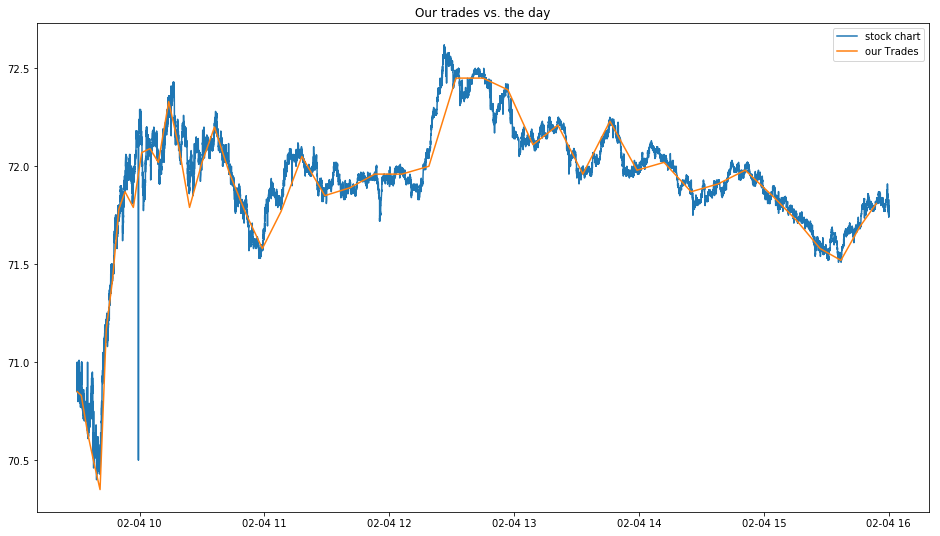

start loop : 2019-05-03 10:59:53:212462
end loop : 2019-05-03 11:01:53:335406
stock volume: 50669815.0
order shares traded: 300000.0
average price: 71.7388443
day vwap: 71.88287033318564
the difference:-0.14402603318563933
average trade size: 1477.8325123152708


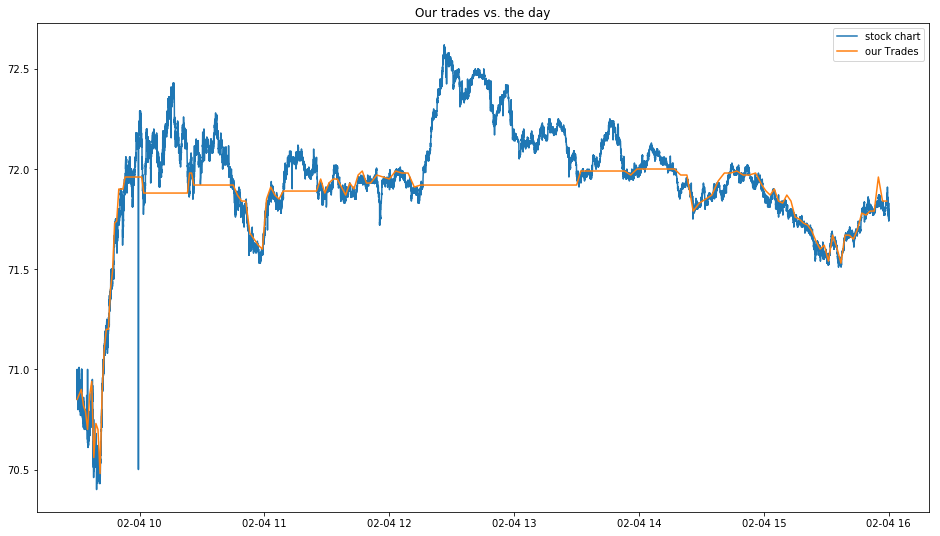

start loop : 2019-05-03 11:01:53:669434
end loop : 2019-05-03 11:03:53:824773
stock volume: 60803778.0
order shares traded: 300000.0
average price: 72.02025686666667
day vwap: 71.88287033318612
the difference:0.13738653348055152
average trade size: 1477.8325123152708


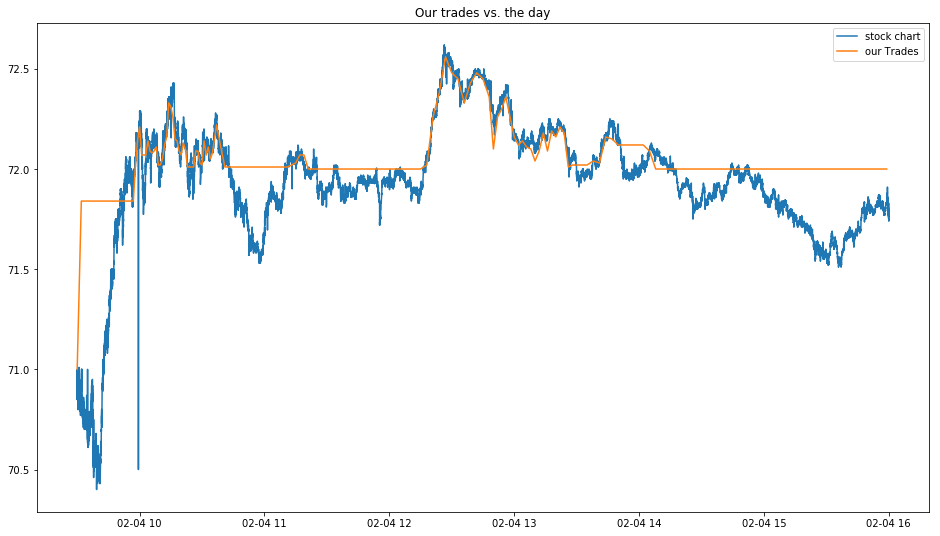

In [51]:
# initialize some other variables


bid_price = 0.0
bid_quantity = 0.0
offer_price = 0.0
offer_quantity = 0.0
last_price = 0.0
last_quantity = 0.0
total_volume = 0.0
vwap_numerator = 0.0

passive_order_live = False
passive_order_price = 0
passive_order_quantity = 0
limit_price = 72
avg_spread = 0.05
trades_amount = 0
average_trades_price = 0
daily_vwap =0
diff_average_trades_price_daily_vwap = 0
n = 1
for n in (1, 2):
    tolerance_threshold = 3000  * n
    for order_side in ('b', 's'):
        current_bar = 1
        current_target = 0
        trades_amount = 0
        quantity_remaining = order_quantity
        quantity_filled = 0
        trades_arr = []
        # main event loop
        show_time( 'start loop' )
        for index, row in taq2.iterrows():
            # figure out which minute we are in after the open
            time_from_open = ( index - pd.Timedelta( hours = 9, minutes = 30 ) )
            minutes_from_open = ( time_from_open.hour * 60 ) + time_from_open.minute
        
            # determine message type
            if ( pd.isnull( row[ 'trade_qty' ] ) ): # it's a quote
                # collect BBO
                bid_price = row[ 'bid_price' ]
                offer_price = row[ 'ask_price' ]
        
                # what's wrong with the lines below?
                bid_quantity = row[ 'bid_qty' ] * 100 
                offer_quantity = row[ 'ask_qty' ] * 100
    
            else: # it's a trade
                last_price = row[ 'trade_price' ]
                last_quantity = row[ 'trade_qty' ]
        
                # collect volume
                total_volume += last_quantity
                # collect rolling VWAP
                vwap_numerator += last_quantity * last_price
        
                # now check to see if we have an order open?
                if passive_order_live:
                    # has our order been hit?
                    if ( (order_side == 'b') and (last_price <= passive_order_price )) or ( (order_side == 's') and (last_price >= passive_order_price)):
                        # we have a trade
                        if quantity_remaining > 0:
                            new_trade_quantity = min( quantity_remaining, last_quantity, passive_order_quantity )
                            quantity_remaining = min( 0, quantity_remaining - new_trade_quantity )
                            quantity_filled += new_trade_quantity  
                            passive_order_live = False
                            trades_amount +=  last_price * new_trade_quantity
                            trades_arr.append( ( last_price, new_trade_quantity, current_bar, index ) )
                            

            # are we in a new minute?
            if ( minutes_from_open > current_bar ):
                # we're in a new bar do new bar things here
                current_bar = minutes_from_open
                current_target = min( np.ceil( order_targets[ current_bar ] ), order_quantity )
                #print ( str(current_bar) + ': ' + str( current_target ) )
        
            # trade logic
            # v1.5: are we behind the target by more than our threshold? If so, do a trade, just pay the spread
            quantity_behind = current_target - quantity_filled
            if ( quantity_behind > tolerance_threshold ): # we need to trade now
        
                # assume you can execute the full size across spread
                new_trade_quantity = quantity_behind
                if ( order_side == 'b'):
                    new_trade_price = offer_price
                elif(order_side == 's'):
                    new_trade_price = bid_price
            
                # do we have a valid last trade price? if not, we should skip, because market data is bad. 
                if ( new_trade_price == 0 ) or ( offer_price - bid_price > 5 * avg_spread ):
                    # something is wrong, wait for market data to update
                    continue
                # update quantity remaining
                quantity_remaining = min( 0, quantity_remaining - new_trade_quantity )
                quantity_filled += new_trade_quantity  
                trades_amount +=  last_price * new_trade_quantity
                trades_arr.append( ( new_trade_price, new_trade_quantity, current_bar, index ) )
         
            else: # we should place a passive order (if we don't already have one out there), (unless we are less than 100 shares!)
                if ( passive_order_live == False ) and ( quantity_behind >= 100 ):
                    passive_order_quantity = quantity_behind
                    if ( order_side == 'b' ):
                        passive_order_price = bid_price
                    else:
                        passive_order_price = offer_price
                    passive_order_live = True
        
        # looping done
        show_time( 'end loop' )
        # Now, let's look at some stats
        #trades = trades.dropna()

        trades_df = pd.DataFrame( trades_arr, columns=[ 'trade_price', 'trade_qty', 'bar', 'time' ] )
        trades_df.index = pd.to_datetime( trades_df[ 'time' ] )
        trades_df = trades_df.drop( columns = ['time'] )
        day_vwap = vwap_numerator / total_volume
        print( 'stock volume: ' + str( total_volume ) )
        print( 'order shares traded: ' + str( quantity_filled ) )
        avg_price = (trades_df[ 'trade_price' ] * trades_df[ 'trade_qty' ]).sum() / trades_df[ 'trade_qty' ].sum()
        print( 'average price: ' + str( avg_price ) )
        print( 'day vwap: ' + str( day_vwap ) )
        print('the difference:' + str(avg_price - day_vwap))
        print( 'average trade size: ' + str( trades_df[ 'trade_qty' ].mean() ) )
        fig, ax1 = plt.subplots( figsize = ( 16, 9 ) )
        ax1.plot( daytrades2[ 'trade_price' ], label = 'stock chart' )
        ax1.plot( trades_df[ 'trade_price' ], label = 'our Trades' )
        plt.title( 'Our trades vs. the day' )
        plt.legend()
        plt.show()

tolerance_threshold = 1000 
for order_side in ('b', 's'):
    current_bar = 1
    current_target = 0
    trades_amount = 0
    quantity_remaining = order_quantity
    quantity_filled = 0
    trades_arr = []
    # main event loop
    show_time( 'start loop' )
    for index, row in taq2.iterrows():
        # figure out which minute we are in after the open
        time_from_open = ( index - pd.Timedelta( hours = 9, minutes = 30 ) )
        minutes_from_open = ( time_from_open.hour * 60 ) + time_from_open.minute
        
        # determine message type
        if ( pd.isnull( row[ 'trade_qty' ] ) ): # it's a quote
            # collect BBO
            bid_price = row[ 'bid_price' ]
            offer_price = row[ 'ask_price' ]
        
            # what's wrong with the lines below?
            bid_quantity = row[ 'bid_qty' ] * 100 
            offer_quantity = row[ 'ask_qty' ] * 100
    
        else: # it's a trade
            last_price = row[ 'trade_price' ]
            last_quantity = row[ 'trade_qty' ]
        
            # collect volume
            total_volume += last_quantity
            # collect rolling VWAP
            vwap_numerator += last_quantity * last_price
        
            # now check to see if we have an order open?
            if passive_order_live:
                # has our order been hit?
                if ( (order_side == 'b') and (last_price <= passive_order_price)) or ( (order_side == 's') and (last_price >= passive_order_price)):
                    # we have a trade
                    if quantity_remaining > 0:
                        new_trade_quantity = min( quantity_remaining, last_quantity, passive_order_quantity )
                        quantity_remaining = min( 0, quantity_remaining - new_trade_quantity )
                        quantity_filled += new_trade_quantity  
                        passive_order_live = False
                        trades_amount +=  last_price * new_trade_quantity
                        trades_arr.append( ( last_price, new_trade_quantity, current_bar, index ) )
 
        # are we in a new minute?
        if ( minutes_from_open > current_bar ):
            # we're in a new bar do new bar things here
            current_bar = minutes_from_open
            current_target = min( np.ceil( order_targets[ current_bar ] ), order_quantity )
            #print ( str(current_bar) + ': ' + str( current_target ) )
        
        # trade logic
        # v1.5: are we behind the target by more than our threshold? If so, do a trade, just pay the spread
        quantity_behind = current_target - quantity_filled
        if ( quantity_behind > tolerance_threshold ): # we need to trade now
        
            # assume you can execute the full size across spread
            new_trade_quantity = quantity_behind
            if ( order_side == 'b') and (limit_price >= offer_price):
                new_trade_price = offer_price
            elif(order_side == 's' ) and (limit_price <= bid_price): 
                new_trade_price = bid_price
            
            # do we have a valid last trade price? if not, we should skip, because market data is bad. 
            if ( new_trade_price == 0 ) or ( offer_price - bid_price > 5 * avg_spread ):
                # something is wrong, wait for market data to update
                continue
                # update quantity remaining
            quantity_remaining = min( 0, quantity_remaining - new_trade_quantity )
            quantity_filled += new_trade_quantity  
            trades_amount +=  last_price * new_trade_quantity        
            trades_arr.append( ( new_trade_price, new_trade_quantity, current_bar, index ) )

        else: # we should place a passive order (if we don't already have one out there), (unless we are less than 100 shares!)
            if ( passive_order_live == False ) and ( quantity_behind >= 100 ):
                passive_order_quantity = quantity_behind
                if ( order_side == 'b' ) and (limit_price >= bid_price):
                    passive_order_price = bid_price
                elif (order_side == 's' ) and (limit_price <= offer_price):
                    passive_order_price = offer_price
                passive_order_live = True
        
    # looping done
    show_time( 'end loop' )
    trades_df = pd.DataFrame( trades_arr, columns=[ 'trade_price', 'trade_qty', 'bar', 'time' ] )
    trades_df.index = pd.to_datetime( trades_df[ 'time' ] )
    trades_df = trades_df.drop( columns = ['time'] )
    day_vwap = vwap_numerator / total_volume
    print( 'stock volume: ' + str( total_volume ) )
    print( 'order shares traded: ' + str( quantity_filled ) )
    avg_price = (trades_df[ 'trade_price' ] * trades_df[ 'trade_qty' ]).sum() / trades_df[ 'trade_qty' ].sum()
    print( 'average price: ' + str( avg_price ) )
    print( 'day vwap: ' + str( day_vwap ) )
    print('the difference:' + str(avg_price - day_vwap))
    print( 'average trade size: ' + str( trades_df[ 'trade_qty' ].mean() ) )
    fig, ax1 = plt.subplots( figsize = ( 16, 9 ) )
    ax1.plot( daytrades2[ 'trade_price' ], label = 'stock chart' )
    ax1.plot( trades_df[ 'trade_price' ], label = 'our Trades' )
    plt.title( 'Our trades vs. the day' )
    plt.legend()
    plt.show()